In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft2
from scipy.signal import find_peaks
import pymc as pm
import arviz as az

In [2]:
def build_model(t, A, P, phi):
    return A * np.cos(2 * np.pi * t / P + phi)

def find_harmonic(t, y, period, lower_period = 200, upper_period = None, sigma_A = None, sigma_sigma = None, 
                  n_samples = 2000, n_tune = 1000, n_chains = 2, n_cores = 2, target_accept = 0.9):
    
    if upper_period is None:
        upper_period = n_years / 2
    if sigma_A is None:
        sigma_A = y.std()
    if sigma_sigma is None:
        sigma_sigma = y.std()
    
    with pm.Model() as first_harmonic:
        # priors
        A = pm.HalfNormal('A', sigma=sigma_A)
        period = pm.Normal('P', mu=period, sigma=0.1 * period)
        phase = pm.Uniform("phi", lower=0, upper=2 * np.pi)
        sigma = pm.HalfNormal("sigma", sigma=sigma_sigma)

        # likelihood
        mu  = A * pm.math.cos(2 * np.pi * t / period + phase)
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
        trace = pm.sample(n_samples, tune=n_tune, chains=n_chains,
                          cores=n_cores,
                          target_accept=target_accept,
                          return_inferencedata=True)
    
    A_hat   = trace.posterior["A"].mean().item()
    P_hat   = trace.posterior["P"].mean().item()
    phi_hat = trace.posterior["phi"].mean().item()
    
    return (A_hat, P_hat, phi_hat)

In [3]:
n_years = 10000

df = pd.read_excel("./data/d18O NGRIP 21.04.24.xlsx", 
                   sheet_name="Raw Data", header=None, 
                   engine="openpyxl")

df_data = df.iloc[10:6124,2:4]
df_data.columns = ["Age", "d18o"]

df_data["Age"] = df_data["Age"] - min(df_data["Age"])
df_data["d18o"] = df_data["d18o"] - np.mean(df_data["d18o"]) 
df_data = df_data[df_data["Age"] <= n_years]

t = df_data["Age"].values.astype("float")
y = df_data["d18o"].values.astype("float")

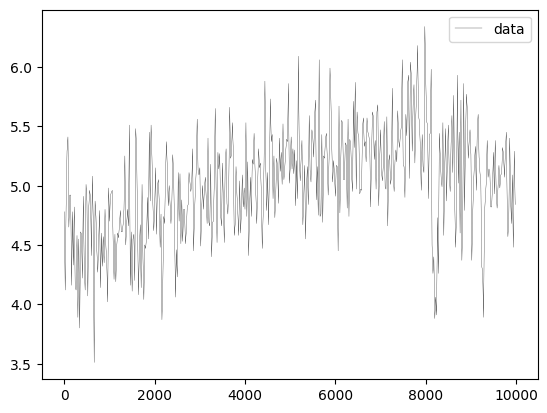

In [4]:
plt.plot(t, y, lw=0.2, c="k", label="data")
plt.legend();

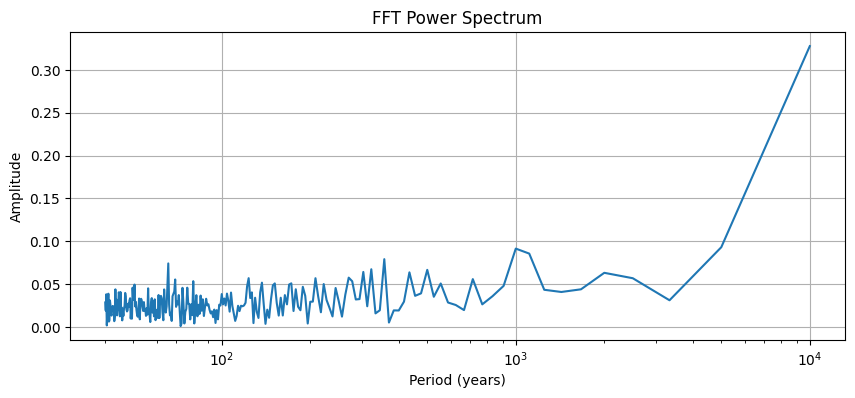

In [5]:
dt = np.median(np.diff(t)) 
t_uniform = np.arange(t[0], t[-1], dt)
y_uniform = np.interp(t_uniform, t, y)  # interpolate to uniform grid

# ---- Step 2: Compute FFT
n = len(t_uniform)
yf = np.fft.fft(y_uniform)
xf = np.fft.fftfreq(n, dt)

# ---- Step 3: Only keep the positive frequencies
positive = xf > 0
frequencies = xf[positive]
amplitudes = 2.0/n * np.abs(yf[positive])  # scaled amplitude

# ---- Step 4: Convert frequency to period (in years)
periods = 1 / frequencies

# ---- Step 5: Plot amplitude spectrum
plt.figure(figsize=(10, 4))
plt.plot(periods, amplitudes)
plt.xscale("log")  # optional: periods vary a lot
plt.xlabel("Period (years)")
plt.ylabel("Amplitude")
plt.title("FFT Power Spectrum")
plt.grid(True)
plt.show()

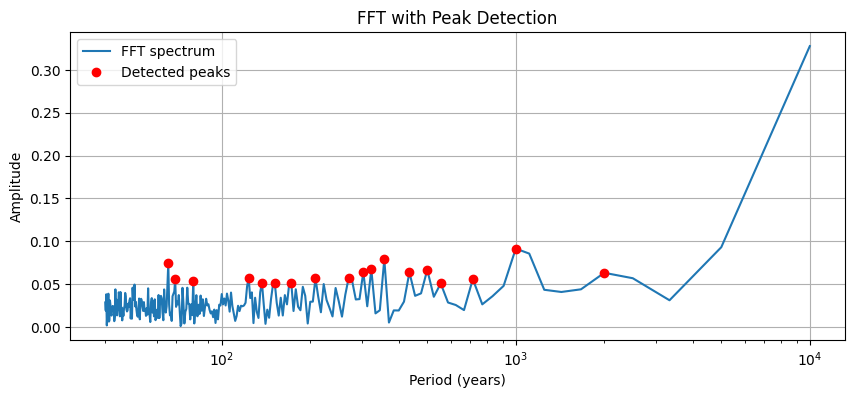

In [6]:
peaks, properties = find_peaks(amplitudes, height=0.05)  # adjust height threshold

peak_periods = periods[peaks]
peak_amplitudes = amplitudes[peaks]

sorted_indices = np.argsort(peak_amplitudes)[::-1]  # descending
top_N = 20
top_periods = peak_periods[sorted_indices][:top_N]
top_amplitudes = peak_amplitudes[sorted_indices][:top_N]

# ---- Plot results ----
plt.figure(figsize=(10, 4))
plt.plot(periods, amplitudes, label="FFT spectrum")
plt.plot(top_periods, top_amplitudes, "ro", label="Detected peaks")
plt.xscale("log")
plt.xlabel("Period (years)")
plt.ylabel("Amplitude")
plt.title("FFT with Peak Detection")
plt.grid(True)
plt.legend()
plt.show()


In [7]:
y_vals = y.copy()
list_models = []
harmonics = {
    "P": [],
    "A": [],
    "phi": []
}
for i in range(len(top_periods)):
    print(f"***** Iteration number {i+1} *******")
    A, P, phi = find_harmonic(t, y_vals, top_periods[i], upper_period=n_years/2, n_samples=2000, n_tune=1000, n_chains = 4, n_cores=4)
    y_model = build_model(t, A, P, phi)
    y_vals -= y_model
    
    list_models.append(y_model)
    
    harmonics["P"].append(P)
    harmonics["A"].append(A)
    harmonics["phi"].append(phi)

df_harmonics = pd.DataFrame(harmonics)

***** Iteration number 1 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


***** Iteration number 2 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


***** Iteration number 3 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


***** Iteration number 4 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


***** Iteration number 5 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


***** Iteration number 6 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


***** Iteration number 7 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


***** Iteration number 8 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


***** Iteration number 9 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


***** Iteration number 10 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


***** Iteration number 11 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


***** Iteration number 12 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


***** Iteration number 13 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


***** Iteration number 14 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


***** Iteration number 15 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


***** Iteration number 16 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


***** Iteration number 17 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


***** Iteration number 18 *******


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, P, phi, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


              P         A       phi
0   1000.109605  0.225288  3.537297
1    357.203351  0.205106  3.271894
2     65.809120  0.203611  3.140364
3    322.281508  0.206346  3.289017
4    499.252243  0.206457  3.364902
5    304.064803  0.216538  3.345460
6    435.671148  0.221784  3.340850
7   2039.758252  0.344184  3.983685
8    270.106839  0.230758  3.224079
9    122.958687  0.219287  3.139989
10   208.446732  0.224688  3.268242
11   713.064707  0.237058  3.392247
12    69.466396  0.227603  3.183153
13    79.856526  0.231956  3.106690
14   136.450854  0.237010  3.207940
15   172.069838  0.233112  3.216247
16   151.432792  0.236347  3.223364
17   555.127878  0.244684  3.326913


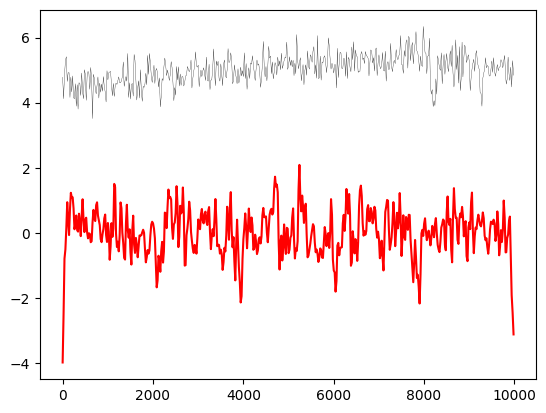

In [8]:
print(df_harmonics)
plt.plot(t, y, lw=0.2, c="k")
plt.plot(t, sum(list_models), c="r");